In [1]:
import os
import re
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import argparse
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import roc_curve
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.stats as stats
import seaborn as sns
from adjustText import adjust_text

In [2]:
d_today = datetime.date.today() 
def parse_args():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--name', default='no_name',
                        help='name of analysis')  
    parser.add_argument('--data_folder', default='DIS_TEST_r2_10',
                        help='data_folder')    
    parser.add_argument('--train_val_data', default='GCN_MAT_pheno_SNP_TEST',
                        help='train_val_data')
    parser.add_argument('--data_folder_test', default='DIS_TEST2_r2_10',
                        help='data_folder')
    parser.add_argument('--test_data', default='GCN_MAT_pheno_SNP_TEST2',
                        help='test_data')
    parser.add_argument('--GWAS_effect', default='None',
                        help='GWAS_effect')
    parser.add_argument('--MHC', default='Include',
                        help='Include: use all snps, Exclude: exclude MHC resion (chr6:26000000-34000000), Only: use only MHC resion (chr6:26000000-34000000)',
                        choices=['Include', 'Exclude', 'Only', 'Impute'])
    parser.add_argument('--Select_file', default='',
                        help='Mainly specifies files that have been LD clumped; files generated from PRSice or PLINK are accepted, but also files generated from make_mat_for_gcn.sh.')
    parser.add_argument('--multi_task', default=[1],
                        help='Specify 1 as it is not yet implemented')
    parser.add_argument('--fold_num', default=5, type=int,
                        help='number of fold')
    parser.add_argument('--p_threshold', nargs='+', type=float, default=[0.01, 0.001, 1.0e-04, 1.0e-05, 1.0e-06, 1.0e-07, 1.0e-08])

    #data for test
    parser.add_argument('--multi_task_test', default=1, type=int,
                        help='Specify 1 as it is not yet implemented') 
    parser.add_argument('--te_samp_max', default=10000, type=int)
    parser.add_argument('--test_model_num', default=1, type=int,
                        help='model name to calculate feature importance')
    parser.add_argument('--analysis_date_for_test', default = str(d_today), type=str,
                        help='date of analysis for test mode')

    # scheduler
    parser.add_argument('--lr', '--learning_rate', default=1e-3, type=float,
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--scheduler', default='CosineAnnealingLR',
                        choices=['CosineAnnealingLR', 'ReduceLROnPlateau', 'MultiStepLR', 'ConstantLR'])
    parser.add_argument('--min_lr', default=1e-6, type=float,
                        help='minimum learning rate')
    parser.add_argument('--factor', default=0.5, type=float)
    parser.add_argument('--patience', default=20, type=int)
    parser.add_argument('--milestones', default='1,2', type=str)
    parser.add_argument('--gamma', default=2/3, type=float)

    #hyper_parameter
    parser.add_argument('--epochs', default=400, type=int, metavar='N',
                        help='number of total epochs to run')
    parser.add_argument('--num_test_model', default=2, type=int,
                        help='Number of GCNs you want to build out of the models registered in models.py (__all__). Constructed in order from the top.')
    parser.add_argument('--num_class', default=2, type=int,
                        help='num_class')
    parser.add_argument('--adj_metric', default='cosine',
                        help='adj_metric')
    parser.add_argument('--adj_parameter', nargs='+', type=int, default=[3],
                        help='adj_parameter')
    parser.add_argument('--init_weight', default='xn')
    parser.add_argument('--reg', default = "elastic", type=str, choices=['elastic', 'l1', 'l2'])
    parser.add_argument('--reg_alpha', default = 0.0001, type=float)
    parser.add_argument('--l1l2_ratio', default = 0.99, type=float)
    parser.add_argument('--dropout', default=0.5)  
    
    args = parser.parse_args(args=['--data_folder', 'RA_WBall_r2_08',
                                   '--data_folder_test', 'RA_non_BWall_r2_08', 
                                   '--MHC', 'Only',
                                   '--Select_file', 'RA_r2_04_WBall.snp',
                                   '--test_model_num', '7',
                                   '--p_threshold', '1.0e-06',
                                   '--analysis_date_for_test', "2023-06-06"
                                  ])
    return args 
config = vars(parse_args())
val_te = "val"
fold = 1
disease = config["data_folder"].split('_')[0]
print(disease)

RA


In [3]:
def find_files_with_keywords(path, keywords):
    matching_files = []
    print("path",path)
    for filename in os.listdir(path):
        if os.path.isdir(os.path.join(path, filename)):
            continue
        if all(keyword in filename for keyword in keywords):

            matching_files.append(filename)
    return matching_files

In [4]:
def create_directory(base_path, folder, test_flag, config):
    directory = os.path.join(
        base_path, folder, folder if not test_flag else config["data_folder_test"],
        f"MHC_{config['MHC']}_adj_{config['adj_parameter'][0]}_p_thre_{config['p_threshold'][0]}"
    )
    os.makedirs(directory, exist_ok=True)
    return directory

def construct_file_name(folder, file_type, config):
    file_name = f"{file_type}_prob_{config['data_folder']}_{config['analysis_date_for_test']}_" \
                f"multi_{'0' if file_type == 'train_val' else config['multi_task_test']}_" \
                f"model_num_{config['test_model_num']}_MHC_{config['MHC']}{config['Select_file']}" \
                f"_reg_{config['reg']}_adj_{config['adj_parameter'][0]}.csv"
    return os.path.join(folder, file_name)

def load_cv_data(path, keywords):
    cv_file = find_files_with_keywords(path, keywords)[0]
    return pd.read_csv(os.path.join(path, cv_file))

def read_csv_with_columns(file_path, header='infer', column_names=None):
    """
    Reads a CSV file and sets the column names if provided.
    """
    df = pd.read_csv(file_path, header=header)
    if column_names:
        df.columns = column_names
    return df

In [5]:
# make ID_label dataframe
BASE_PATH = "igraph_prac"
test_flag = val_te == "te"
folder = config["data_folder_test"] if val_te == "te" else config["data_folder"]
file_type = "test" if val_te == "te" else "train_val"

prob_file_name = construct_file_name(folder, file_type, config)

try:
    prob = pd.read_csv(prob_file_name, index_col=0)
except FileNotFoundError:
    print(f"File not found: {prob_file_name}")

path = os.path.join(config["data_folder"], "cv")
cv_tr = load_cv_data(path, ["train", str(fold-1)])    
if not test_flag:
    cv_val = load_cv_data(path, ["val", str(fold-1)])
    prob = prob.iloc[len(cv_tr):, fold-1:]

# Making test/evaluation ID DataFrame
te_id = pd.DataFrame(prob.index.to_list(), columns=["ID"])
print("Length of test sample:", len(te_id))

# Paths for training ID and label files
tr_id_path = f"{config['data_folder']}/p_thre_{config['p_threshold'][0]}/{fold-1}_tr_val/id_tr.csv"
tr_label_path = f"{config['data_folder']}/p_thre_{config['p_threshold'][0]}/{fold-1}_tr_val/labels_tr1.csv"

# Reading training ID and label DataFrames
tr_id = read_csv_with_columns(tr_id_path)
tr_label = read_csv_with_columns(tr_label_path, header=None, column_names=["label"])

# Combining training ID and label into a single DataFrame
tr_id_lab = pd.concat([tr_id, tr_label], axis=1)
tr_id_lab.columns = ["ID", "label"]

# Constructing file paths and reading data for validation/test set
base_path = config["data_folder_test"] if val_te == "te" else config["data_folder"]
p_threshold_path = f"p_thre_{config['p_threshold'][0]}"
fold_path = f"0_test" if val_te == "te" else f"{fold-1}_tr_val"

if val_te == "te":
    # Constructing file paths for test IDs and labels
    te_id_paths = os.path.join(base_path, p_threshold_path, fold_path, "id_te.csv")
    te_label_paths = os.path.join(base_path, p_threshold_path, fold_path, "labels_te1.csv") 
    
    # Reading and concatenating test IDs and labels
    te_ids = read_csv_with_columns(te_id_paths) 
    te_labels = read_csv_with_columns(te_label_paths, header=None, column_names=["label"])

    # Combining IDs and labels and merging with te_id
    te_idlab_all = pd.concat([te_ids, te_labels], axis=1)
    te_id_lab = pd.merge(te_id, te_idlab_all, on="ID")
    te_label = te_id_lab[["label"]]
    
elif val_te == "val":
    # Reading validation labels
    te_label_path = os.path.join(base_path, p_threshold_path, fold_path, "labels_te1.csv")
    te_label = read_csv_with_columns(te_label_path, header=None, column_names=["label"])

    # Combining validation IDs and labels
    te_id_lab = pd.concat([te_id, te_label], axis=1)

# Final DataFrame for test/validation IDs and labels
te_id_lab.columns = ["ID", "label"]

# Creating index dictionary for training and test/validation sets
trte_idx = {"tr": list(range(len(cv_tr)))}

# Assigning test/validation indices based on val_te value
if val_te == "te":
    trte_idx["te"] = list(range(len(cv_tr), len(cv_tr) + len(prob)))
elif val_te == "val":
    trte_idx["te"] = list(range(len(cv_tr), len(cv_tr) + len(cv_val)))

# Preparing labels for test/validation and combined labels list
labels_te_list = te_label
combined_labels = pd.concat([tr_label, te_label], axis=0).iloc[:, 0].to_list()

# Concatenating training and test/validation ID-label DataFrames
# and resetting index for the combined DataFrame
combined_id_label_df = pd.concat([tr_id_lab, te_id_lab], axis=0).reset_index(drop=True)

combined_id_label_df = combined_id_label_df.reset_index()

path RA_WBall_r2_08\cv
path RA_WBall_r2_08\cv
Length of test sample: 4000


In [6]:
#calculate cutoff_result
fpr, tpr, thresholds = roc_curve(labels_te_list, prob[str(config["p_threshold"][0])+f"_{fold-1}"])
Youden_index_candidates = tpr-fpr
index = np.where(Youden_index_candidates==max(Youden_index_candidates))[0][0]
cutoff = thresholds[index]
cutoff_result = np.where(prob[str(config["p_threshold"][0])+f"_{fold-1}"]< cutoff, 0, 1)

In [7]:
#add color to each patient
color_list_te = []
j=1
k=0

for i in combined_labels:
    if j <= len(combined_labels)-len(cutoff_result):
        if i==1:
            color_list_te.append('r')
        else:
            color_list_te.append('b') 
    else:
        if i==1 and cutoff_result[k]==1: #True positive
            color_list_te.append('m')   
        elif i==1 and cutoff_result[k]==0: #false negative
            color_list_te.append('g')
        elif i==0 and cutoff_result[k]==0: #True negative
            color_list_te.append('c')
        else: #false positive
            color_list_te.append('y')
        k+=1
    j+=1 

#add color columns
combined_id_label_df["color"] = color_list_te
combined_id_label_df

igraph_path = f"igraph_prac/{config['data_folder']}/{base_path}/MHC_{config['MHC']}_adj_{str(config['adj_parameter'][0])}_p_thre_{str(config['p_threshold'][0])}/{fold-1}/"
#save and load color list
pd.DataFrame(color_list_te).to_csv(igraph_path + f"color_list_te_1_full", index=False)
color_list_te = pd.read_csv(igraph_path + f"/color_list_te_1_full")

The following cell loads a dataframe for HLA imputation. We used Data-field 22182 from the UKBiobank (https://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=22182). This HLA imputation dataframe (hla) is being merged with another dataframe that combines id and label (combined_id_label_df).

In [8]:
if val_te == "val":
    hla = pd.read_csv("HLA/UKB/ukb49777_HLA_22182_WB.txt", sep=" ", header = None)
elif val_te == "te":
    hla = pd.read_csv(f"HLA/UKB/ukb49777_HLA_22182_{disease}.txt", sep=" ", header = None)
header = pd.read_csv("HLA/UKB/ukb_hla_v2.txt", sep="\t") 
hla.columns = ["ID"] + list(header)

col_hla = pd.merge(combined_id_label_df, hla, on="ID").iloc[0:,0:]
col_hla = col_hla.loc[:, (col_hla != 0).any(axis=0)]
color_df = col_hla[["ID", "color"]]

In [9]:
#read adj matrix
adj_all_trte_I = np.load(igraph_path +'/adj_numpy.npy')

#Assign color labels to nodes that are not isolated.
nx_G = nx.from_numpy_array(adj_all_trte_I)
nx.write_gml(nx_G, igraph_path + f"/cv_te_1_full.gml")
G_rem_te=[]

id = 0
id_list_te = []
for v in nx_G:
    G_deg=nx_G.degree(v)
    if G_deg<=1:
        G_rem_te.append(v)
    else:
        id_list_te.append(id)
    id += 1    

node_deg_list = pd.DataFrame(color_list_te).iloc[id_list_te].values.tolist()
color_list_resi_te = []
for i in node_deg_list:
    color_list_resi_te.extend(i)

In [10]:
#Here, we specify HLA-DRB1*04:01, an HLA risk allele for rheumatoid arthritis.
target_hla="DRB1_401"

#Assign red to homozygous samples for HLA risk alleles, green to heterozygous samples, and blue to samples with null values.
col_hla[target_hla + "_c"] = col_hla[target_hla].round(0).map({2.0: "r", 1.0: "g", 0.0: "b"})

nx_G = nx.from_numpy_array(adj_all_trte_I)
nx_G.remove_nodes_from(G_rem_te)
nx_G.remove_edges_from(nx.selfloop_edges(nx_G)) #derete self loop

id_color_list=[]
for i in range (len(color_list_resi_te)):
    id_color_list.append([list(nx_G.nodes)[i], color_list_resi_te[i]])
id_color_df = pd.DataFrame(id_color_list)
id_color_df.columns = ["index", "color"]
id_color_df_tr = pd.merge(combined_id_label_df, id_color_df, on=["index", "color"])
target_hla_df = pd.merge(id_color_df_tr, col_hla, on=["ID", "color"])

DRB1_401_c


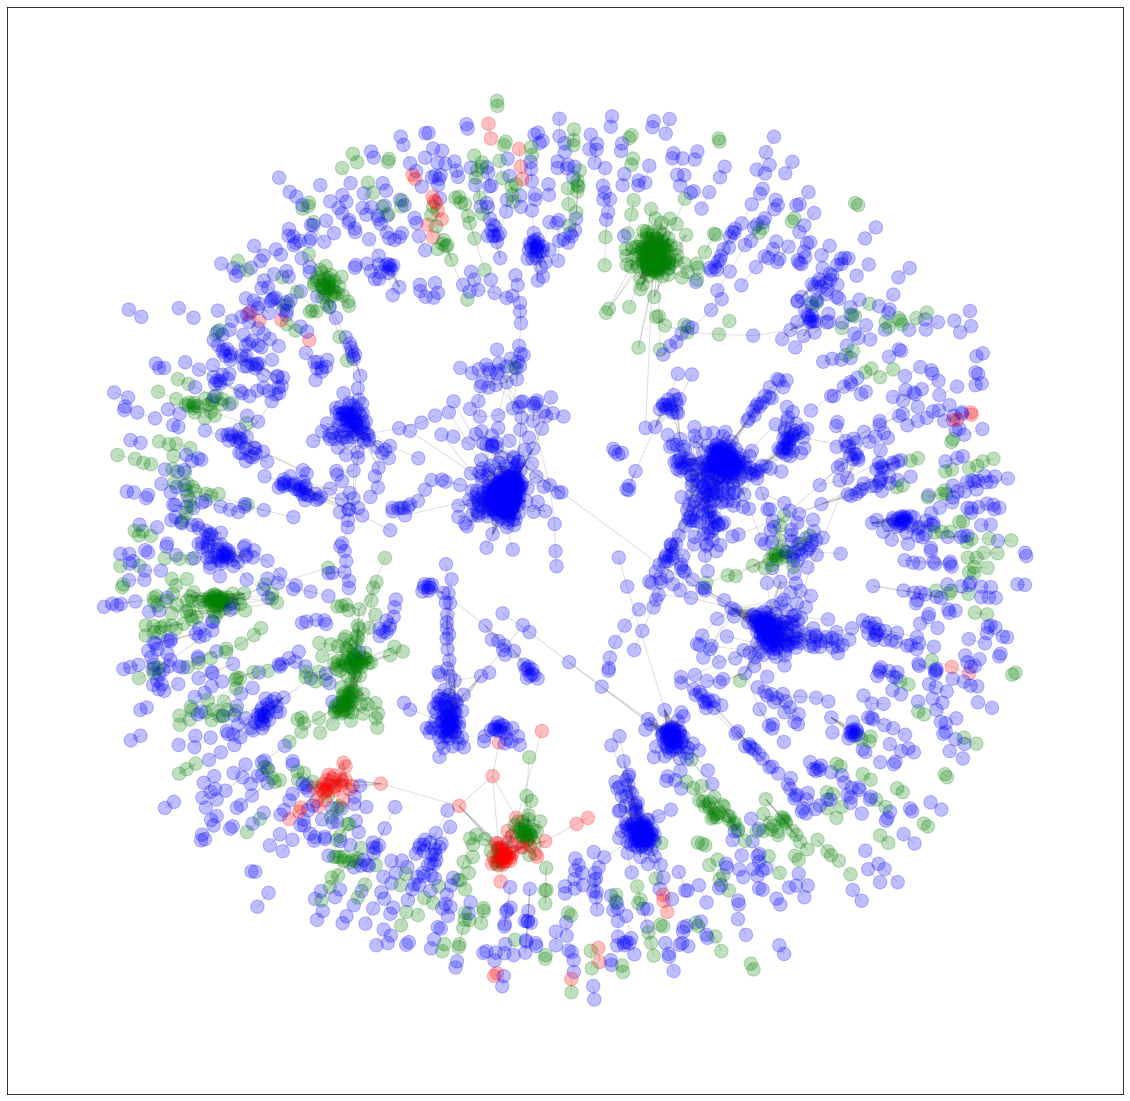

In [11]:
node_af=nx_G.number_of_nodes() #number of node
edge_af=nx_G.number_of_edges() #number of edge
pos = nx.spring_layout(nx_G, seed=41)

plt.figure(figsize=(20,20))
print(target_hla + "_c")
nx.draw_networkx(nx_G, pos, node_color = target_hla_df[target_hla + "_c"], alpha=0.25, node_size=180, with_labels=False, edge_color="gray")
plt.show()

===== entire data =====
number of sample in each cluster sorted in descending order       id  node_num
2      2       503
9      9       283
10    10       145
29    29       114
18    18       106
..   ...       ...
265  265         2
263  263         2
262  262         2
260  260         2
587  587         2

[588 rows x 2 columns]


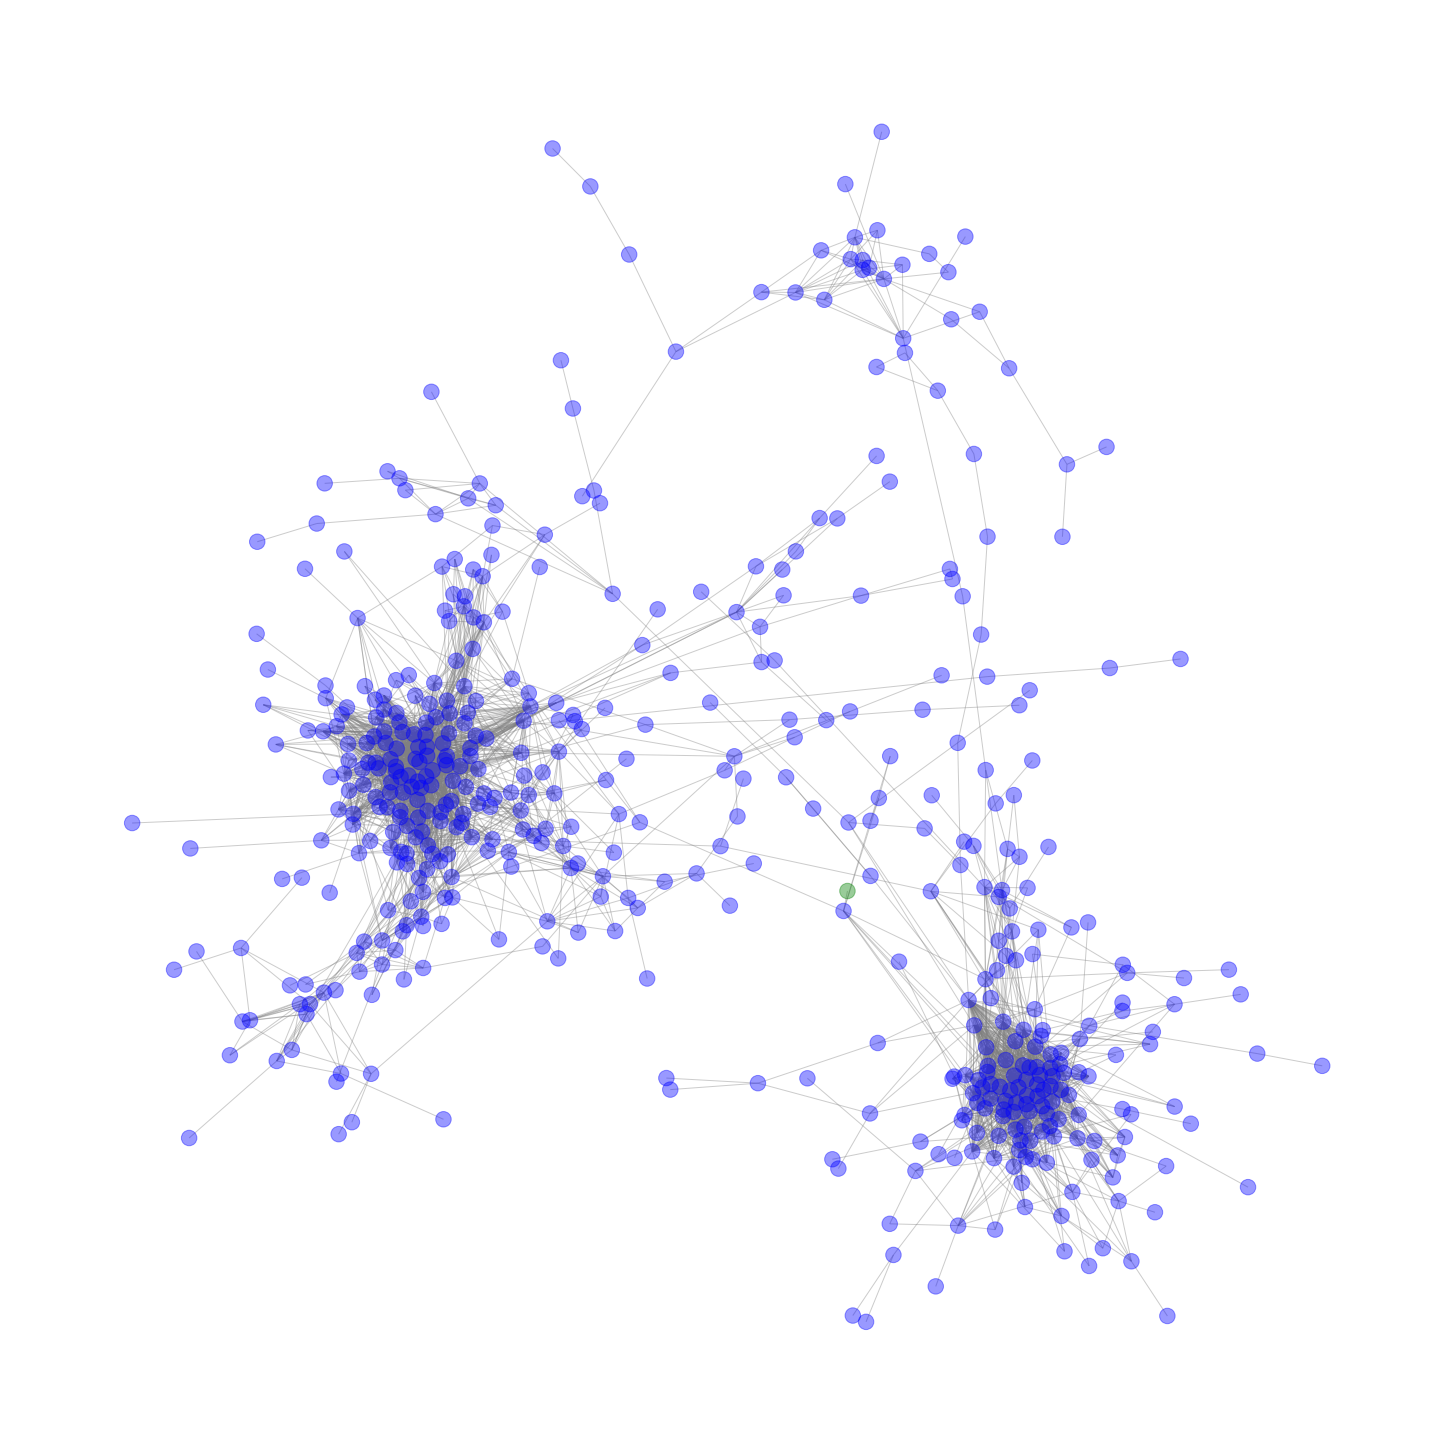

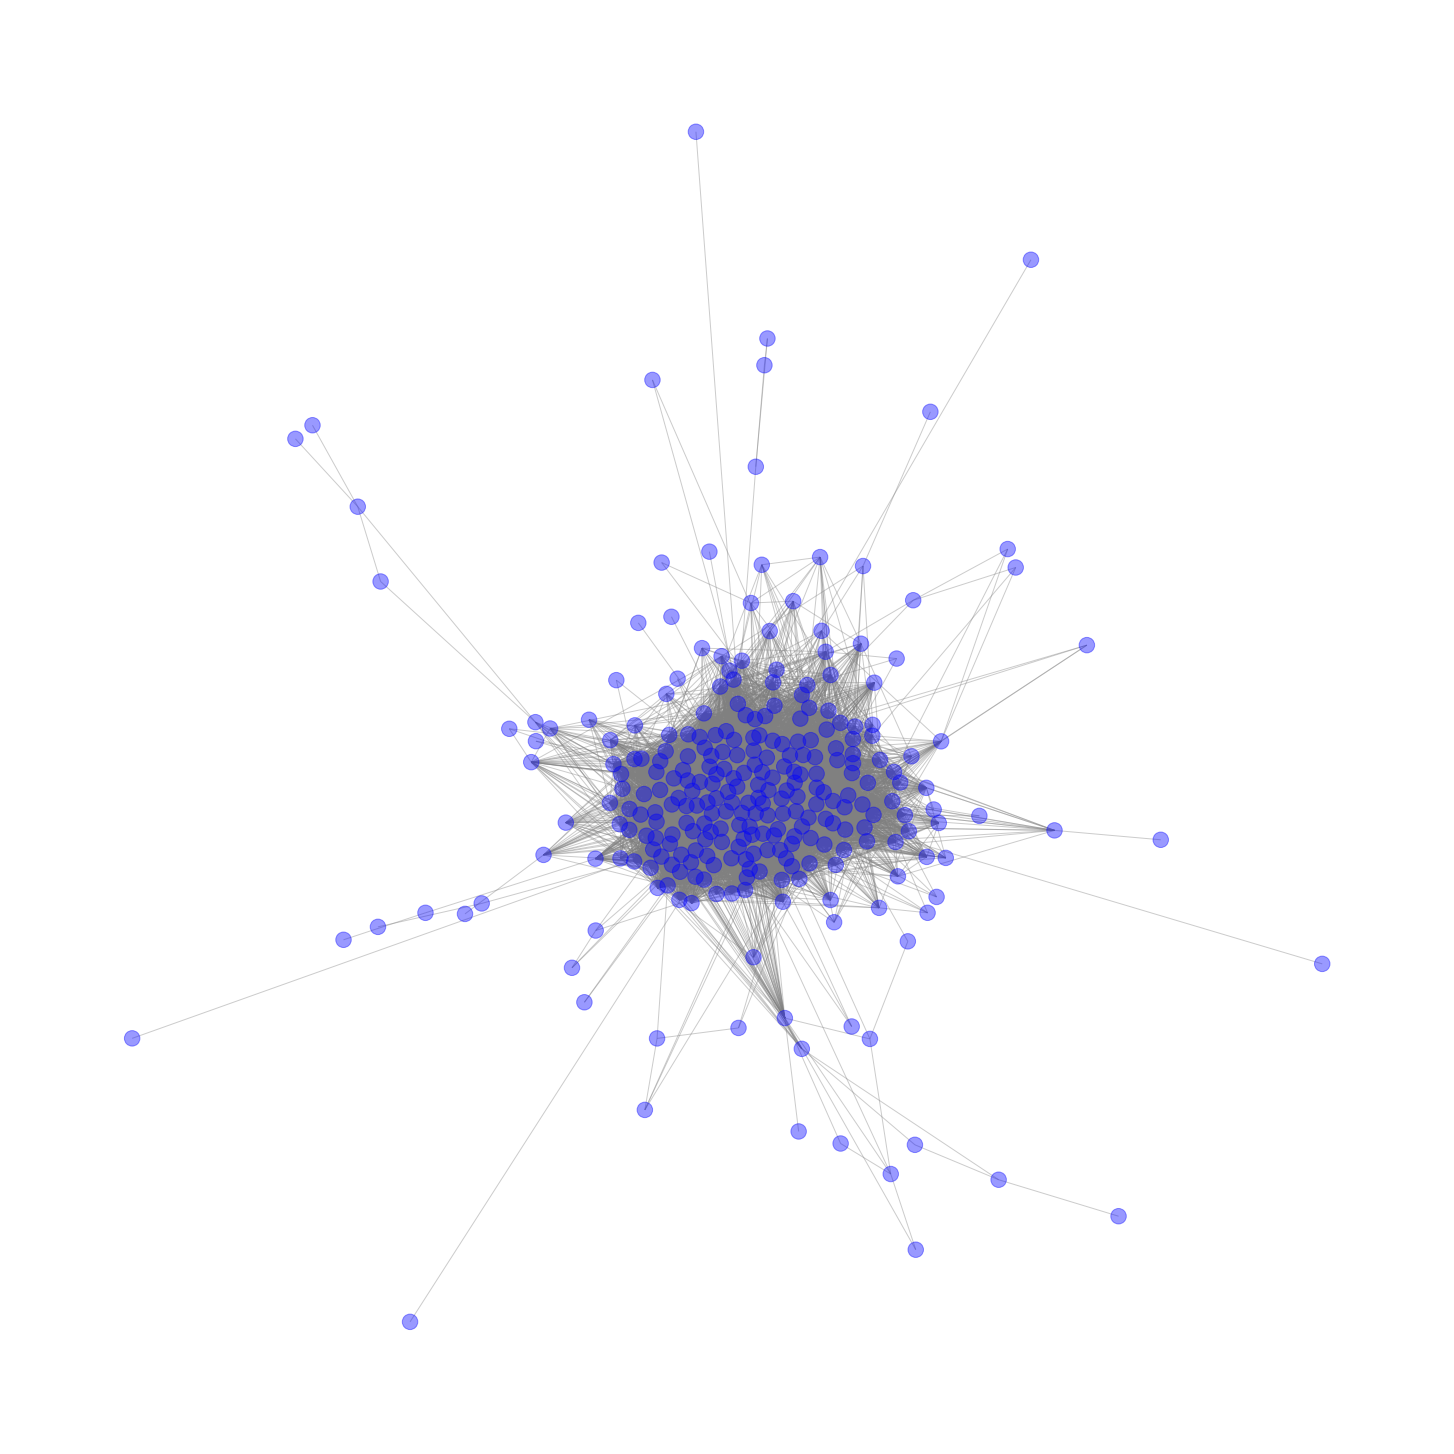

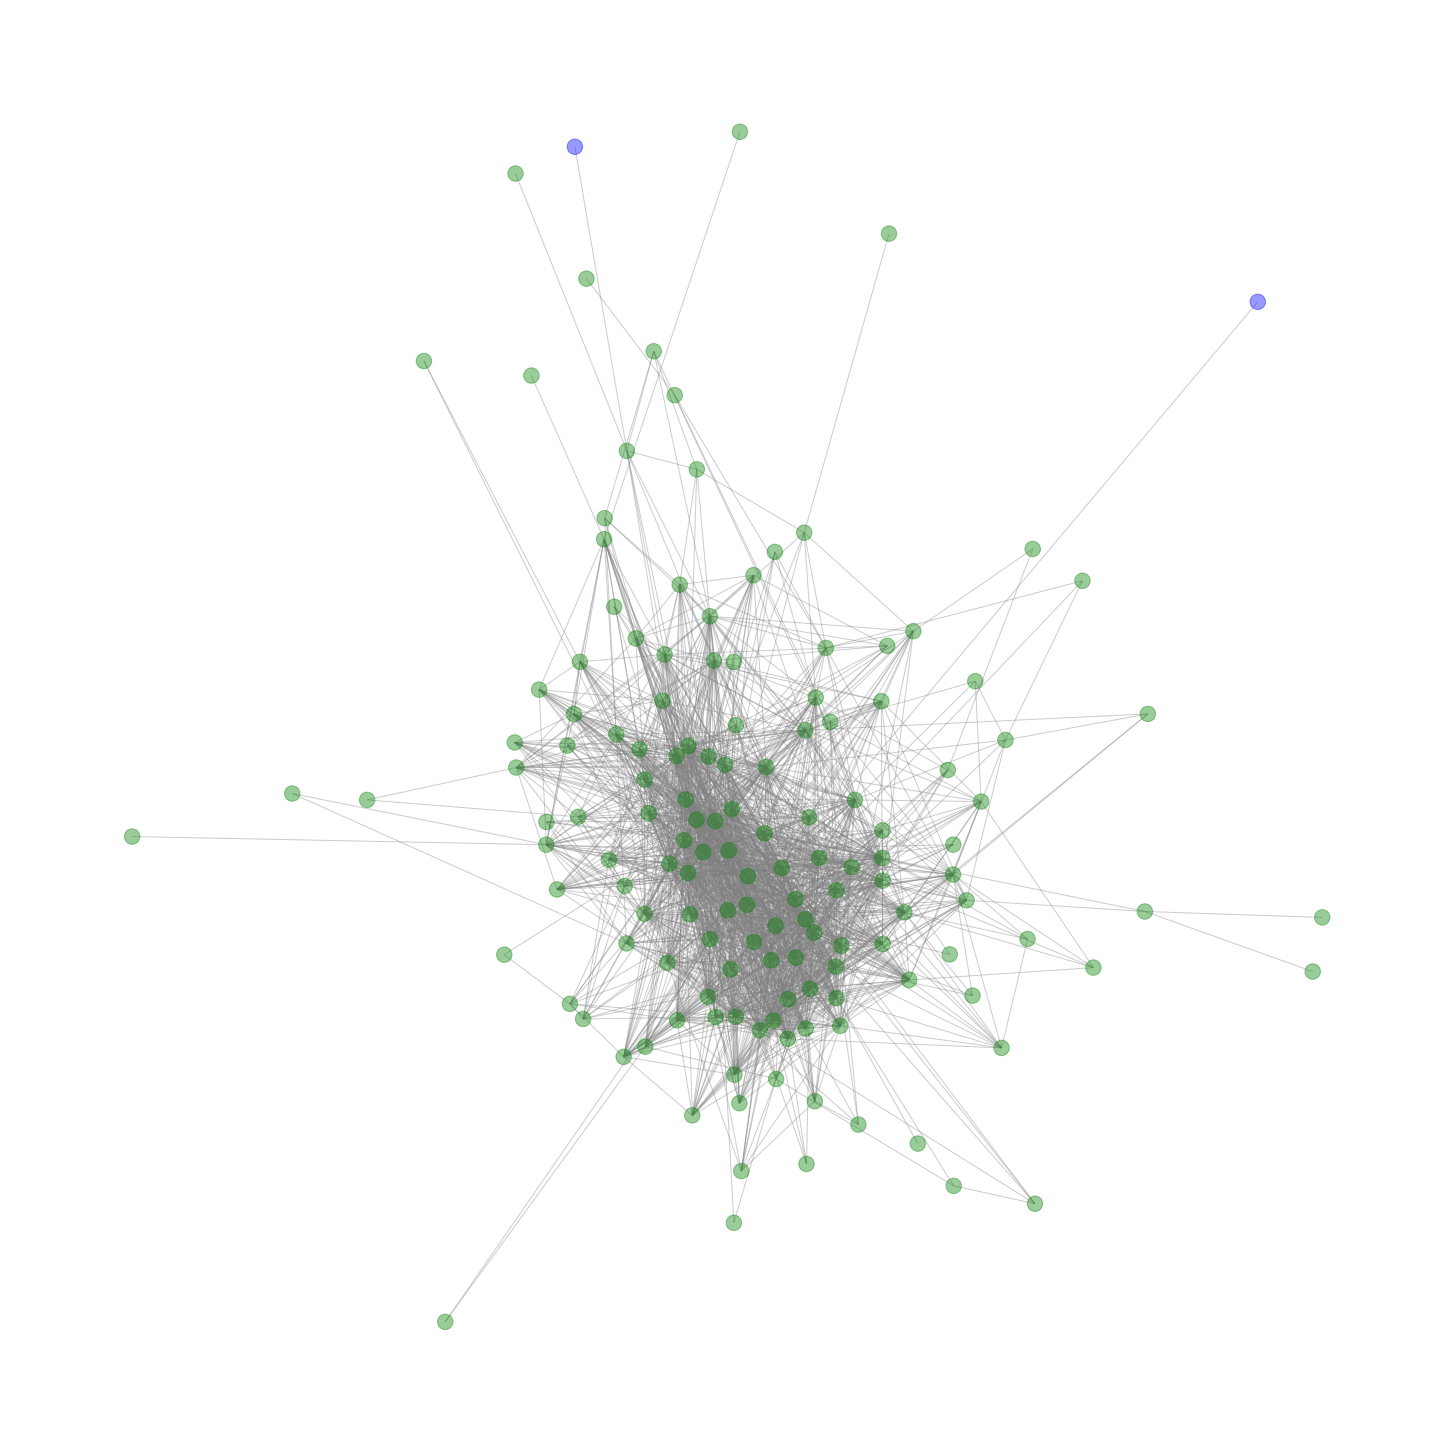

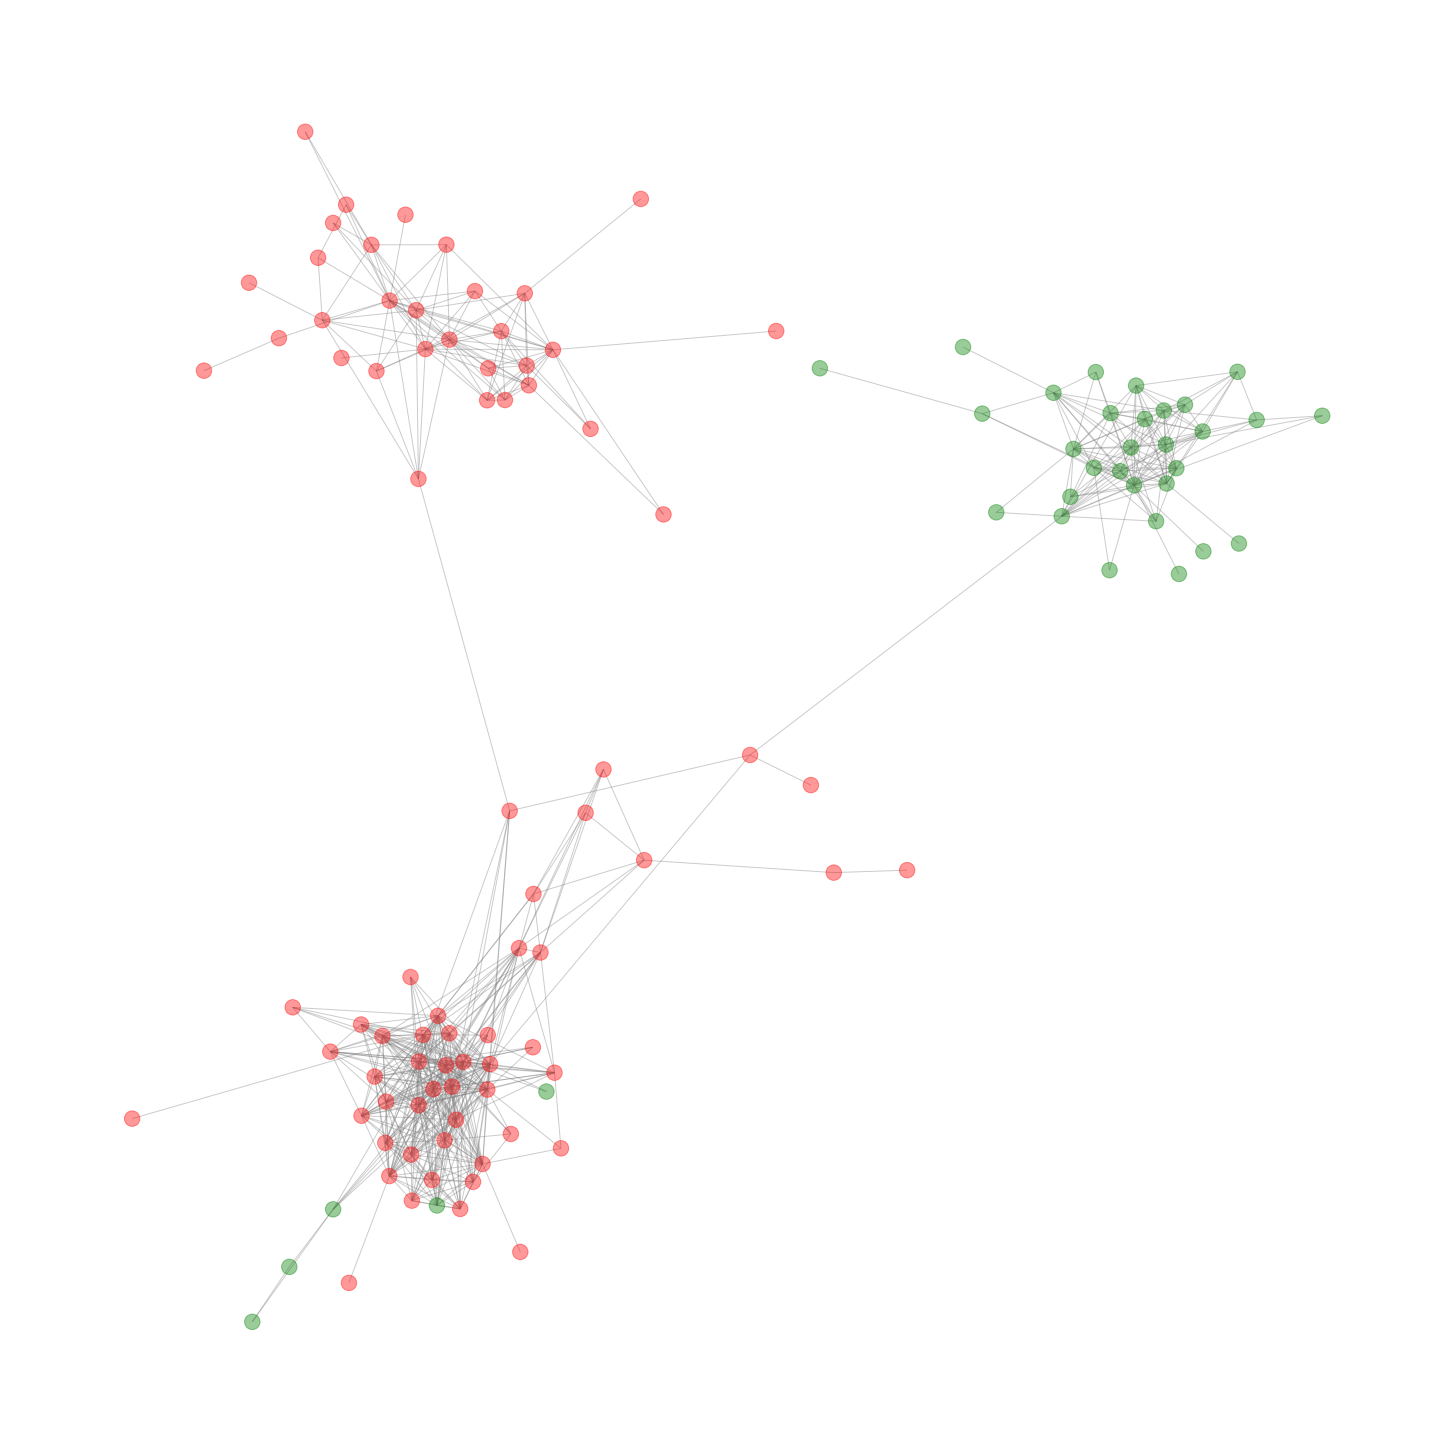

In [12]:
id_color_list=[]
for i in range (len(nx_G.nodes)):
    id_color_list.append([list(nx_G.nodes)[i], target_hla_df[target_hla + "_c"][i]])
id_color_df = pd.DataFrame(id_color_list)
id_color_df.columns = ["index", target_hla + "_c"]
id_color_df_tr = pd.merge(combined_id_label_df, id_color_df, on=["index"])
id_color_df_tr

S = []
S_color_df = []
for c in nx.connected_components(nx_G):
    c_df = pd.DataFrame(list(c))
    c_df.columns = ["index"]
    c_df_color = pd.merge(c_df, id_color_df, on="index")
    S.append(nx_G.subgraph(c).copy())
    S_color_df.append(c_df_color)

S = [nx_G.subgraph(c).copy() for c in nx.connected_components(nx_G)]
print("="*5, "entire data", "="*5)
length_list = []
for i in range(len(S)):
    length_list.append([i,len(S[i])])
subgraph_df = pd.DataFrame(length_list)
subgraph_df.columns = ["id", "node_num"]
subgraph_dfs = subgraph_df.sort_values('node_num', ascending=False)
print("number of sample in each cluster sorted in descending order", subgraph_dfs)

sub_pos = []
for i in range(4):
    sub_pos.append(nx.spring_layout(S[subgraph_dfs.iloc[i,0]], seed=42))
    plt.figure(figsize=(20,20))
    nx.draw(S[subgraph_dfs.iloc[i,0]], sub_pos[i], node_color = S_color_df[subgraph_dfs.iloc[i,0]][target_hla + "_c"], alpha=0.4, node_size=240, edge_color="gray")
    plt.show()


In [13]:
node_id_list = []
for i in range(len(S)):
    node_ID = pd.merge(id_color_df_tr[["index", "ID"]], S_color_df[subgraph_dfs.iloc[i,0]], on="index")
    node_id_list.append(pd.merge(node_ID, col_hla, on=["ID"]))
node_id_list

import collections

inc_iso=True

clusters = {}
keys = ['b', 'r', 'c', 'm', 'g', 'y']

for i in range(4):
    c = collections.Counter(node_id_list[i]["color"])
    for key in keys:
        if key not in c:
            c[key] = 0
    clusters[f"C{i+1}"] = dict(c)

if inc_iso==True:
    #to generate isolated node data
    all_ids = [id for df in node_id_list for id in df['ID'].tolist()]
    isolate = color_df[~color_df['ID'].isin(all_ids)]
    c = collections.Counter(isolate["color"])    
    clusters[f"C{i+2}"] = dict(c)

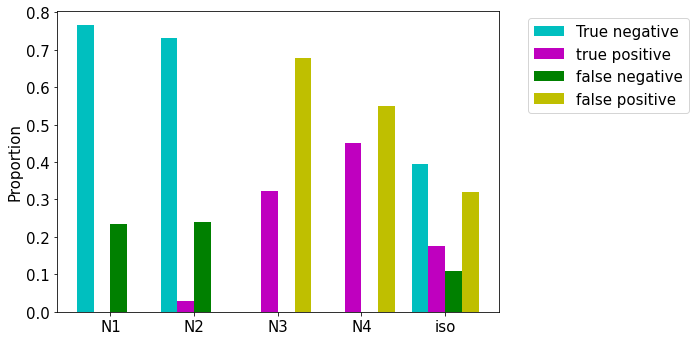

In [14]:
plt.rcParams["font.size"] = 15

if inc_iso==True:
    labels = ['N1', 'N2', 'N3', 'N4', 'iso']
else:
    labels = ['N1', 'N2', 'N3', 'N4']
c_vals = []
m_vals = []
g_vals = []
y_vals = []

for c in clusters:
    total = sum([clusters[c][i] for i in ['c', 'm', 'g', 'y']])
    c_vals.append(clusters[c]['c'] / total)
    m_vals.append(clusters[c]['m'] / total)
    g_vals.append(clusters[c]['g'] / total)
    y_vals.append(clusters[c]['y'] / total)

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - 3*width/2, c_vals, width, label='True negative', color='c')
rects2 = ax.bar(x - width/2, m_vals, width, label='true positive', color='m')
rects3 = ax.bar(x + width/2, g_vals, width, label='false negative', color='g')
rects4 = ax.bar(x + 3*width/2, y_vals, width, label='false positive', color='y')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion')
#ax.set_title('Proportion of c, m, g, y in each cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Place legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.tight_layout()
plt.show()


- We are using SnpEff to assign gene names to each SNP. Therefore, we output a file after merging GWAS data with the LRP score file.

In [16]:
GWAS = "TransEthnic_hg19.TransE_IOR2_UKB_QC_nodup_common.PRSice"

r_score = pd.read_csv(f'{base_path}/r_score{fold-1}_{config["MHC"]}.csv')
r_score = pd.concat([color_df, r_score], 1)

r_score_m = pd.DataFrame(r_score.mean().sort_values(ascending=False)).reset_index()
r_score_m.columns = ["SNP", "score"]

gwas = pd.read_csv(f"GWAS_stat/{disease}/{GWAS}", sep=" ")

r_score_gwas = pd.merge(r_score_m, gwas, on="SNP")
r_score_gwas["-log10P"] = -np.log10(r_score_gwas["P"]+1.0e-300)

r_score_gwas[["SNP", "CHR", "BP", "A1", "A2", "P", "OR"]].to_csv( f'volcano/prsice_snp_%s_%s.txt' % (disease, config['MHC']), sep=" ", index=False)

In [18]:
#The following is a shell script command used to assign gene names using SnpEff.
"""
file_name="prsice_snp_RA_Only.txt"

awk '{print $2"\t"$3"\t"$1"\t"$5"\t"$4"\t" "\t" "\t" }' ${file_name} > ${file_name}.vcf

sed -i '1d' ${file_name}.vcf

sed -i '1i#CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO' ${file_name}.vcf

snpEff -v -stats -Xmx4G report.html GRCh37.75 ${file_name}.vcf > ${file_name}_anno.vcf

awk -F'\t' '{ split($8,arr,"|"); print $3 "\t" arr[4] }' ${file_name}_anno.vcf > ${file_name}_anno.id_gname 
"""

'\nfile_name="prsice_snp_RA_Only.txt"\n\nawk \'{print $2"\t"$3"\t"$1"\t"$5"\t"$4"\t" "\t" "\t" }\' ${file_name} > ${file_name}.vcf\n\nsed -i \'1d\' ${file_name}.vcf\n\nsed -i \'1i#CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO\' ${file_name}.vcf\n\nsnpEff -v -stats -Xmx4G report.html GRCh37.75 ${file_name}.vcf > ${file_name}_anno.vcf\n\nawk -F\'\t\' \'{ split($8,arr,"|"); print $3 "\t" arr[4] }\' ${file_name}_anno.vcf > ${file_name}_anno.id_gname \n'

- In the first code, we are loading a dataframe that has been assigned gene names using SnpEff.

In [17]:
gene_names = pd.read_csv(f'volcano/prsice_snp_%s_%s.txt_anno.id_gname' % (disease, config['MHC']), sep="\t", header=None)
gene_names.columns = ["SNP", "Gene_name"]

snp_ids = gene_names["SNP"]

gene_name_id = [f"{gene}_{snp}" for gene, snp in zip(gene_names["Gene_name"], snp_ids)]
gene_names["gene_name_id"] = gene_name_id
gene_names = gene_names.sort_values('SNP').reset_index(drop='True')

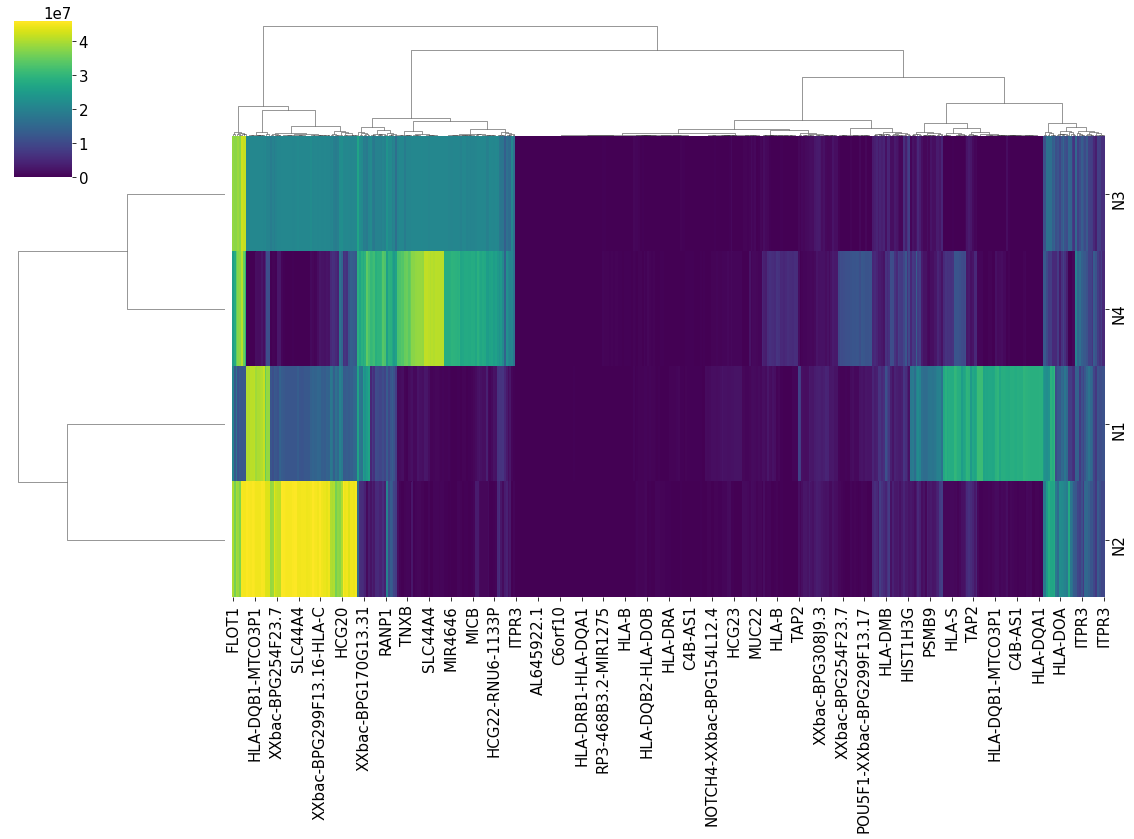

In [19]:
cluster_num = 4  

id_color_r_score = r_score[['ID', 'color']]
r_score_d = r_score.drop(['ID', 'color'], axis=1)
r_score_d.columns= gene_names["gene_name_id"]

all_ids = [id for df in node_id_list for id in df['ID'].tolist()]
isolate_rscore = r_score[~r_score['ID'].isin(all_ids)].iloc[0:,2:]
hla_rscore = []
c_rscore = []

for i in range(cluster_num):
    hla_rscore.append(pd.merge(node_id_list[i], r_score, on=["ID", "color"]))
    c_rscore.append(hla_rscore[i].iloc[0:,-len(gene_names):])
    c_rscore[i].columns = r_score_d.columns
    
r_score_all = r_score.drop(['ID', 'color'], axis=1)
r_score_all.columns = r_score_d.columns
merge_clu = pd.concat([pd.DataFrame(c_rscore[0].mean()),pd.DataFrame(c_rscore[1].mean()),pd.DataFrame(c_rscore[2].mean()),pd.DataFrame(c_rscore[3].mean()),pd.DataFrame(r_score_all.mean())],1)
merge_clu.columns = ["N1", "N2", "N3", "N4", "all"]

merge_clu.index = merge_clu.index.map(lambda x: re.sub('_chr6:.*', '', x))
g = sns.clustermap(merge_clu.iloc[0:,0:4].T, method='ward', cmap='viridis', figsize=(16, 12))
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

plt.show()

In [20]:
#Compare the LRP scores of two connected networks using a Volcano plot. 
#The number of the largest connected cluster in terms of sample size is 0, followed by 1, 2, 3, etc. 
#Specify any two of these numbers below for comparison.
cluster1_num = 0
cluster2_num = 3

all_ids = [id for df in node_id_list for id in df['ID'].tolist()]
isolate_rscore = r_score[~r_score['ID'].isin(all_ids)].iloc[0:,2:]

hla_rscore1 = pd.merge(node_id_list[cluster1_num], r_score, on=["ID", "color"])
hla_rscore2 = pd.merge(node_id_list[cluster2_num], r_score, on=["ID", "color"])

c1_rscore = hla_rscore1.iloc[0:,-len(gene_names):]
c2_rscore = hla_rscore2.iloc[0:,-len(gene_names):]

C:\Users\anaconda3\envs\pytorch\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


481


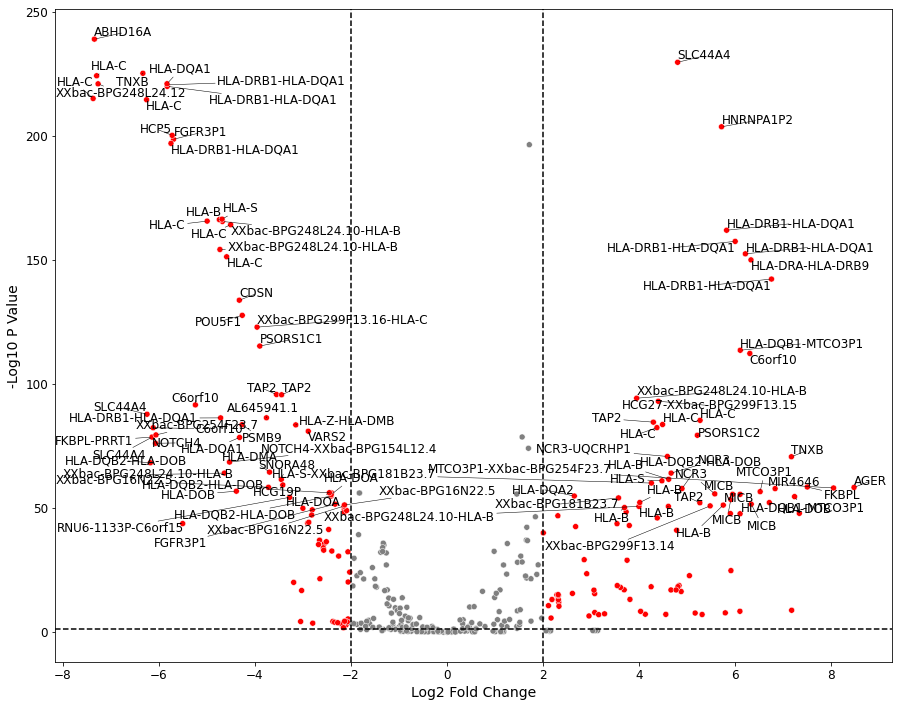

In [21]:
isolate_rscore.columns = gene_names["Gene_name"]
c1_rscore.columns = gene_names["Gene_name"]
c2_rscore.columns = gene_names["Gene_name"]

# Calculate the means for each genotype in each cluster
c1_means = c1_rscore.mean()
c2_means = c2_rscore.mean()

# Compute the log2 fold changes
log2fc = np.log2(c2_means / c1_means).replace({np.inf: np.nan, -np.inf: np.nan})
print(len(log2fc))
# Perform a t-test for each genotype
_, p_values = stats.ttest_ind(c1_rscore, c2_rscore, axis=0, equal_var=False, nan_policy='omit')

p_values = np.where(p_values==0, np.nan, p_values)

# Apply -log10 transformation to p-values
neg_log10_p_values = -np.log10(p_values)

# Prepare a DataFrame for plotting
df = pd.DataFrame({
    'log2fc': log2fc,
    'neg_log10_p_value': neg_log10_p_values
})
df = df.replace([np.inf, -np.inf], np.nan)
# Add a new column for gene names
df['gene'] = c1_rscore.columns
df = df.dropna()

# Convert DataFrame to dictionary
gene_names_dict = gene_names.set_index('SNP')['Gene_name'].to_dict()

# Set the thresholds
log2fc_threshold = 2
p_value_threshold = 0.05
display_threshold = 50

# Create a new column in the DataFrame for the colors
df['color'] = 'grey'  # Default color
df.loc[((df['log2fc'] <= -log2fc_threshold) | (df['log2fc'] >= log2fc_threshold)) & (df['neg_log10_p_value'] >= np.log10(1/p_value_threshold)), 'color'] = 'red'

# Create the volcano plot
plt.figure(figsize=(15, 12))
plot = sns.scatterplot(data=df, x='log2fc', y='neg_log10_p_value', hue='color', palette=['grey', 'red'], hue_order=['grey', 'red'], legend=False)

# Annotate gene names for SNPs with high -log10 p-value
texts = []
for line in range(0, df.shape[0]):
    if (df.neg_log10_p_value.iloc[line] > display_threshold)&((df.log2fc[line] > log2fc_threshold)|(df.log2fc[line] < -log2fc_threshold)):
        texts.append(plot.text(df.log2fc.iloc[line], df.neg_log10_p_value.iloc[line], df.gene.iloc[line], horizontalalignment='left', size='medium', color='black', fontsize=12))  # adjust fontsize here

# Adjust text positions
adjust_text(texts, force_points=0.4, force_text=0.2, expand_points=(1,1), expand_text=(1,1), arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xlabel('Log2 Fold Change', fontsize=14)
plt.ylabel('-Log10 P Value', fontsize=14)
#plt.title('Volcano Plot')

# Adjust tick label size
plt.tick_params(axis='both', which='major', labelsize=12)

# Draw the threshold lines
plt.axhline(y=-np.log10(p_value_threshold), color='black', linestyle='--')
plt.axvline(x=-log2fc_threshold, color='black', linestyle='--')
plt.axvline(x=log2fc_threshold, color='black', linestyle='--')

#plt.xlim(-6, 6)
#plt.ylim(0, 100) 
plt.show()
